## 0. Importing necessary libraries

In [1]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

import re
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import TfidfTransformer
from keras.preprocessing.text import text_to_word_sequence
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score

from xgboost import XGBClassifier

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Prepare data

In [4]:
import sys
sys.path.insert(0, '/content/drive/MyDrive/ML/preprocessing')
import Preprocessor

### 1.1. Load data

In [5]:
import tensorflow_datasets as tfds
dataset = tfds.load('imdb_reviews', as_supervised=False)

In [6]:
X_train, y_train, X_test, y_test = Preprocessor.load_prep(dataset)  

### 1.2. TF-IDF Vectorisation

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

def func(doc):  # n_jobs in GridSearch does not support lambda function
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=func,
    preprocessor=func) 

tfidf.fit(X_train)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


TfidfVectorizer(preprocessor=<function func at 0x7fc90152fcb0>,
                tokenizer=<function func at 0x7fc90152fcb0>)

In [8]:
X_train_tf = tfidf.transform(X_train)
X_test_tf = tfidf.transform(X_test)

## 2. Model training

### 2.1. Default hyperparameter values

In [9]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [10]:
rf = RandomForestClassifier(random_state=0)
lr = LogisticRegression(random_state=0)
dt = DecisionTreeClassifier(random_state=0)

for clf in(rf, lr, dt):
  clf.fit(X_train_tf, y_train)
  y_pred_train = clf.predict(X_train_tf)
  y_pred_test = clf.predict(X_test_tf)

  train_acc = accuracy_score(y_train, y_pred_train)
  test_acc = accuracy_score(y_test, y_pred_test)
  print("classifier: ", clf.__class__.__name__)
  print("train: ", train_acc)
  print("test: ", test_acc)

classifier:  RandomForestClassifier
train:  1.0
test:  0.84704
classifier:  LogisticRegression
train:  0.93748
test:  0.88176
classifier:  DecisionTreeClassifier
train:  1.0
test:  0.71336


In [25]:
clf = VotingClassifier(
    estimators=[('rf', rf), ('lr', lr), ('dt', dt)],
    voting='soft'
)
clf.fit(X_train_tf, y_train)

y_pred_train = clf.predict(X_train_tf)
y_pred_test = clf.predict(X_test_tf)

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)
print("classifier: ", clf.__class__.__name__)
print("train: ", train_acc)
print("test: ", test_acc)

classifier:  VotingClassifier
train:  1.0
test:  0.78876


## 2.2. Hyperparameter tuning

### 2.2.1. Random Forest

We tried tuning `n_estimators`, `max_depth` to increase the accuracy of the model. However, the tuning does not seem to help much, thus we kept default values for these. The `criterion` hypyerparameter is tuned to yield *entropy* as the best.

In [12]:
rf = RandomForestClassifier(random_state=0, criterion='entropy')
rf.fit(X_train_tf, y_train)

y_pred_train = rf.predict(X_train_tf)
y_pred_test = rf.predict(X_test_tf)

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)
print("classifier: Random Forest")
print("train: ", train_acc)
print("test: ", test_acc)

classifier: Random Forest
train:  1.0
test:  0.85128


### 2.2.2. Logistic Regression

After tuning using GridSearchCV, we yield that `C` makes the most significant impact on the accuracy, with the optimal value of 2.

In [13]:
lr = LogisticRegression(C=2)
lr.fit(X_train_tf, y_train)

y_pred_train = lr.predict(X_train_tf)
y_pred_test = lr.predict(X_test_tf)

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)
print("classifier: Logistic Regression")
print("train: ", train_acc)
print("test: ", test_acc)

classifier: Logistic Regression
train:  0.9574
test:  0.88332


### 2.2.3. Decision Tree

In [26]:
dt = RandomForestClassifier(random_state=0, criterion='entropy')
dt.fit(X_train_tf, y_train)

y_pred_train = dt.predict(X_train_tf)
y_pred_test = dt.predict(X_test_tf)

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)
print("classifier: Decision Tree")
print("train: ", train_acc)
print("test: ", test_acc)

classifier: Decision Tree
train:  1.0
test:  0.85128


### 2.2.3. Voting Classifier

After tuning the base classifiers, Voting Classifier is called again to see the difference.

In [31]:
rf = RandomForestClassifier(random_state=0, criterion='entropy')
lr = LogisticRegression(C=2, random_state=0)
dt = DecisionTreeClassifier(criterion='entropy', random_state=0)

clf = VotingClassifier(
    estimators=[('rf', rf), ('lr', lr), ('dt', dt)]
)
clf.fit(X_train_tf, y_train)

y_pred_train = clf.predict(X_train_tf)
y_pred_test = clf.predict(X_test_tf)

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)
print("classifier: ", clf.__class__.__name__)
print("train: ", train_acc)
print("test: ", test_acc)

classifier:  VotingClassifier
train:  1.0
test:  0.86932


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


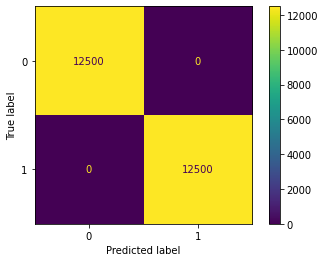

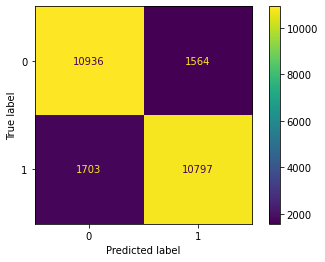

In [33]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_train_tf, y_train)  
plot_confusion_matrix(clf, X_test_tf, y_test)

## 3. Predicting new instances

In [34]:
# positive review
sentence = "Was foolishly overthought about watching it at cinemas, due to criticism, but the movie was actually a welcomed change to the previous marvel phase setup, it was not boring at any point for the duration of the movie and it was interesting to see how easily things can go really bad that even Thanos Crusade that was the big deal can seem so simple and trivial.Some comments that i noticed complained about 'not enough multiverse etc etc' the movie was not called Doctor Strange visits any other universe :) the movie played with multiverse and showed some different ways that interacting with one another can have a number of unpredictable results .If someone wants a more deep dive into the theme i suggest to watch Loki series, there its explained and shown in a slower pace with more detailOverall a Solid entry for the Genre, and honestly most of the negative comments and chatter can be applied for the most marvel movies out there if taken serious!"

In [35]:
review = pd.Series(sentence)
stop_words = set(stopwords.words("english"))
review_clean = review.map(lambda x: Preprocessor.clean_text(x, word_tokenize, stop_words))

In [36]:
review_tf = tfidf.transform(review_clean)

In [37]:
print(review_clean)

0    [foolishly, overthought, watching, cinemas, du...
dtype: object


In [38]:
clf.predict(review_tf)

array([0])

In [39]:
# negative review
sentence2 = "After months of hype, we are left with a mess of a story that is mostly just CGI blobs, some light shows and some boring dialogue. I loved the first Strange movie, its my second favorite after Captain America Winter Soldier. So this was extra disappointing.Firstly, youre not going to have any idea whats going on with the main antagonist unless you watched the Disney+ show Wandavision. Even though I did watch it, it had been months, and I didnt remember all the details, so her whole backstory fell flat. This movie was less about Strange and more about her.Theres also a subplot involving Stranges old flame, but since we only saw them as exes in the previous film, it Didnt really feel that impactful.Theres also an obligatory teen sidekick, which I guess is now standard in the Phase IV fully Disneyized MCU. She might have been interesting, but shes just there as a macguffiin and has no real personality.Theres also random cameos from other Marvel properties, Im beginning to see these bits of crossover fan service are the sole purpose of having a multiverse.Seriously, I dont know why I keep giving my money to this franchise. Black Widow, Eternals, Shang Chi and now Dr Strange 2, have all been dull, uninspired CGI crap fests, that rely entirely on cameos and fan service to keep people coming back. Lets just face it, Hollywood milked all they could from Marvel. Its time to give the franchise ( and maybe all superhero movies)a good 10-15 year rest and reboot it after audiences grow nostalgic."
review_clean2 = pd.Series(sentence2).map(lambda x: Preprocessor.clean_text(x, word_tokenize, stop_words))

In [40]:
clf.predict(tfidf.transform(review_clean2))

array([0])